<a href="https://colab.research.google.com/github/iamsoroush/face_vae/blob/master/face_vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
#@title # Imports {display-mode: "form"}

# Upgrade tensorflow to latest stable version
!pip install --upgrade tensorflow-gpu

import json
import zipfile
import os
import psutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io as skio
import skimage.transform as sktrans

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import Model, Sequential, metrics, optimizers
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Conv2D,\
                                    MaxPooling2D, UpSampling2D, GlobalAveragePooling2D,\
                                    Layer, Lambda,Flatten, Reshape, Conv2DTranspose,\
                                    Activation, LeakyReLU, Dropout, InputLayer
import tensorflow.keras.backend as K
from tensorflow.keras.applications import VGG19

Requirement already up-to-date: tensorflow-gpu in /usr/local/lib/python3.6/dist-packages (1.14.0)


In [2]:
#@title # Prepare data {display-mode: "form"}
#@markdown Set the batch size:

batch_size = 64 #@param {type:"slider", min:8, max:128, step:8}

def crop_resize_normalize(item):
    """Use this function as first mapping to raw dataset.
    
    This function gets items from tensorflow celeb_a dataset one-by-one,
     and crops the face in image based on landmarks, then resizes the cropped
     face to (128, 128) and normalizes that to (0, 1). At return, returns whole
     item with image replaces by new generated face.
    """
    img = item['image']
    landmarks = item['landmarks']
    
    # Get lefteye and righteye coordinates
    lx, ly = landmarks['lefteye_x'], landmarks['lefteye_y']
    rx, ry = landmarks['righteye_x'], landmarks['righteye_y']
    
    # lefteye will be in (0.3, 0.3) coordinates on cropped image,
    # so we will calculate lefteye to border based on lefteye position
    le_to_border = tf.cast(tf.cast(rx - lx, tf.float32) * 0.75, tf.int64)
    
    # Calculate top-left position of face
    offset_height = ly - le_to_border
    offset_width = lx - le_to_border
    
    # Calculate height and width of bounding box
    target_height = tf.cast(tf.cast(le_to_border, tf.float32) * 10 / 3, tf.int64)
    target_width = target_height
    
    # Handle this condition: bounding box exxeeds image dimensions
    width, height = img.shape[-3: -1]
    target_height = tf.cond(offset_height + target_height > height,
                            lambda: tf.subtract(tf.cast(height, tf.int64),
                                                offset_height),
                            lambda: target_height)
    target_width = tf.cond(offset_width + target_width > width,
                            lambda: tf.subtract(tf.cast(width, tf.int64),
                                                offset_width),
                            lambda: target_width)
    
    # Crop image
    cropped = tf.image.crop_to_bounding_box(img, offset_height, offset_width,
                                            target_height, target_width)
    
    # Normalize and resize image
    resized = tf.image.resize(tf.cast(cropped, tf.float32) / 255.0, [128, 128])
    item['image'] = resized
    return item


def preprocess(image):
    # Returns image, image because when training, vae expects same input image as output
    image = image['image']
    return image, image

def preprocess_test(image):
    return image['image']

def smiling_preprocess(batch):
    imgs = batch['image']
    smiling = batch['attributes']['Smiling']
    return imgs[smiling]

def not_smiling_preprocess(batch):
    imgs = batch['image']
    smiling = batch['attributes']['Smiling']
    return imgs[~smiling]


# Download data
data, info = tfds.load("celeb_a", with_info=True)
train_data, val_data, test_data = data['train'], data['validation'], data['test']

steps_per_epoch = info.splits['train'].num_examples // batch_size
validation_steps = info.splits['validation'].num_examples // batch_size

# Define train, validation and test datasets
train_ds = train_data.map(crop_resize_normalize).map(preprocess).repeat().batch(batch_size).prefetch(1)
val_ds = val_data.map(crop_resize_normalize).map(preprocess).repeat().batch(batch_size).prefetch(1)
test_ds = test_data.map(crop_resize_normalize).map(preprocess_test).repeat().batch(batch_size).prefetch(1)

# Define smiling and not-smiling datasets
attr_data = tfds.load("celeb_a", split=tfds.Split.ALL)
smiling_ds = attr_data.map(crop_resize_normalize).batch(batch_size).map(smiling_preprocess)
not_smiling_ds = attr_data.map(crop_resize_normalize).batch(batch_size).map(not_smiling_preprocess)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is be

W0707 07:32:38.122089 139793099880320 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_datasets/core/file_format_adapter.py:209: tf_record_iterator (from tensorflow.python.lib.io.tf_record) is deprecated and will be removed in a future version.
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset celeb_a downloaded and prepared to /root/tensorflow_datasets/celeb_a/0.3.0. Subsequent calls will reuse this data.


W0707 07:36:51.441841 139793099880320 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/array_ops.py:1354: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
#@title # Define the model {display-mode: "form"}

# 

def encoder_network(input_shape, latent_dim=100):
    def sampling(args):
        z_mean, z_log_var = args
        epsilon_mean = 0
        epsilon_std = 1.0
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                                  mean=epsilon_mean, stddev=epsilon_std)
        sampled_z = z_mean + K.exp(z_log_var / 2) * epsilon
        return sampled_z
    
    input_img = Input(shape=input_shape)
    x = Conv2D(32, 4, strides=(2, 2))(input_img)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(64, 4, strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(128, 4, strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(256, 4, strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(512, 4, strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = GlobalAveragePooling2D()(x)

    z_mean = Dense(latent_dim, name='mean')(x)
    z_log_var = Dense(latent_dim)(x)
    z = Lambda(sampling)([z_mean, z_log_var])

    encoder = Model(input_img, z)
    return encoder, z_mean, z_log_var

def decoder_network(latent_dim=100):
    decoder_input = Input(shape=(latent_dim,))
    x = Dense(4096)(decoder_input)
    x = Reshape((4, 4, 256))(x)

    x = UpSampling2D((2, 2), interpolation='nearest')(x)
    x = Conv2D(128, 3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = UpSampling2D((2, 2), interpolation='nearest')(x)
    x = Conv2D(64, 3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = UpSampling2D((2, 2), interpolation='nearest')(x)
    x = Conv2D(32, 3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = UpSampling2D((2, 2), interpolation='nearest')(x)
    x = Conv2D(16, 3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = UpSampling2D((2, 2), interpolation='nearest')(x)
    x = Conv2D(3, 3, strides=1, padding='same', activation='sigmoid')(x)

    decoder = Model(decoder_input, x)
    return decoder

def perceptual_loss(x, z_decoded):
    h1_list = model(x)
    h2_list = model(z_decoded)
    
    rc_loss = 0.0
    
    for h1, h2, weight in zip(h1_list, h2_list, selected_pm_layer_weights):
        h1 = K.batch_flatten(h1)
        h2 = K.batch_flatten(h2)
        rc_loss = rc_loss + weight * K.mean(K.sum(K.square(h1 - h2), axis=-1))
    return rc_loss

def perceptual_corr_loss(x, z_decoded):
    h1_list = model(x)
    h2_list = model(z_decoded)
    
    rc_loss = 0.0
    
    for h1, h2, weight in zip(h1_list, h2_list, selected_pm_layer_weights):
        h1 = K.batch_flatten(h1)
        h2 = K.batch_flatten(h2)
        
        mean_1 = tf.reduce_mean(h1, axis=-1)
        mean_2 = tf.reduce_mean(h2, axis=-1)
        h1 = tf.subtract(h1, tf.expand_dims(mean_1, 1))
        h2 = tf.subtract(h2, tf.expand_dims(mean_2, 1))
        h = tf.multiply(h1, h2)
        numerator = tf.reduce_mean(h, axis=-1)
        denominator = K.std(h1, axis=-1) * K.std(h2, axis=-1)
        if denominator == 0:
            continue
        else:
            rc_loss = rc_loss + weight * tf.reduce_mean(numerator / denominator)
    return rc_loss

def kl_loss():
    kl = K.mean(-0.5 * K.sum(1 + z_log_var \
                      - K.square(z_mean) \
                      - K.exp(z_log_var), axis=-1))
    return kl

def reconstruction_loss(x, t_decoded):
    '''Reconstruction loss for the plain VAE'''
    return K.mean(K.sum(K.binary_crossentropy(
        K.batch_flatten(x), 
        K.batch_flatten(t_decoded)), axis=-1))

def vae_loss(x, z_decoded):
    '''Total loss for the DFC VAE'''
    return 5e-1 * reconstruction_loss(x, z_decoded) + kl_loss()
  
def vae_dfc_loss(x, z_decoded):
    '''Total loss for the DFC VAE'''
    return 5e-1 * perceptual_loss(x, z_decoded) + kl_loss()

# Train and test models

In [4]:
#@title # Train plain vae {display-mode: "form"}
#@markdown Set latent space dimension and number of epochs for training:

latent_dim = 100 #@param {type:"slider", min:50, max:150, step:10}
epochs = 3 #@param {type:"slider", min:1, max:10, step:1}


input_shape = (128, 128, 3)

encoder, z_mean, z_log_var = encoder_network(input_shape, latent_dim)
z_encoded = encoder.output
decoder = decoder_network(latent_dim)
z_decoded = decoder(z_encoded)

vae = Model(encoder.input, z_decoded)

opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)

vae.compile(optimizer=opt, loss=vae_loss)

train_iterator = train_ds.make_one_shot_iterator()
val_iterator = val_ds.make_one_shot_iterator()

vae.fit(train_iterator,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=val_iterator,
        validation_steps=validation_steps)

W0707 07:55:31.472498 139793099880320 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0707 07:55:32.882876 139793099880320 deprecation.py:323] From <ipython-input-4-ea934a05fbf3>:21: DatasetV1.make_one_shot_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


Epoch 1/3
2543/2543 [==============================] - 766s 301ms/step - loss: 14165.5109 - val_loss: 14059.4288
Epoch 2/3
2543/2543 [==============================] - 776s 305ms/step - loss: 13986.8780 - val_loss: 13997.8486
Epoch 3/3
2543/2543 [==============================] - 765s 301ms/step - loss: 13954.4849 - val_loss: 13982.1372


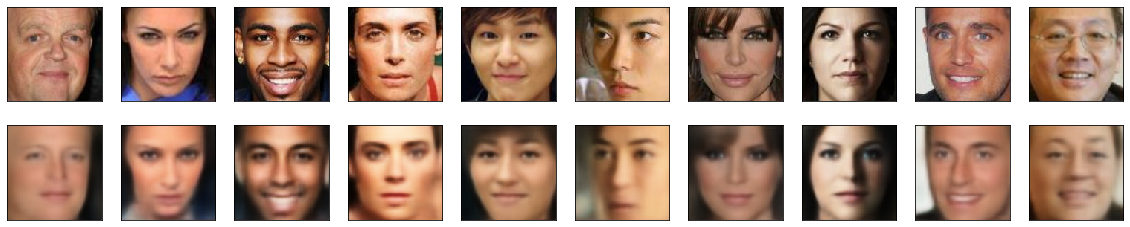

In [5]:
#@title # Test plain vae {display-mode: "form"}

n = 10
generator = test_ds.make_one_shot_iterator()
x_test = generator.get_next()[0]
x_test = tfds.as_numpy(x_test)
code = Model(encoder.input, encoder.get_layer('mean').output)
encoded_imgs = code.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [10]:
#@title # Train DFC-VAE with loss defined on layers 1, 2, 3 {display-mode: "form"}

#@markdown Set latent space dimension and number of epochs for training:

latent_dim = 100 #@param {type:"slider", min:50, max:150, step:10}
epochs = 3 #@param {type:"slider", min:1, max:10, step:1}

pm = VGG19(include_top=False, weights='imagenet', input_shape=(128, 128, 3))

selected_pm_layers = ['block1_conv2', 'block2_conv2', 'block3_conv2']
selected_pm_layer_weights = [0.6, 0.8, 1.0]
outputs = [pm.get_layer(l).output for l in selected_pm_layers]
model = Model(pm.input, outputs)

input_shape = (128, 128, 3)

encoder, z_mean, z_log_var = encoder_network(input_shape, latent_dim)
z_encoded = encoder.output
decoder = decoder_network(latent_dim)
z_decoded = decoder(z_encoded)

vae = Model(encoder.input, z_decoded)

opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)

vae.compile(optimizer=opt, loss=vae_dfc_loss)

train_iterator = train_ds.make_one_shot_iterator()
val_iterator = val_ds.make_one_shot_iterator()
vae.fit(train_iterator,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=val_iterator,
        validation_steps=validation_steps)

Epoch 1/3
2543/2543 [==============================] - 3358s 1s/step - loss: 1049477.8008 - val_loss: 838041.8244
Epoch 2/3
2543/2543 [==============================] - 3398s 1s/step - loss: 797131.6333 - val_loss: 758432.6687
Epoch 3/3
2543/2543 [==============================] - 3431s 1s/step - loss: 749910.0552 - val_loss: 735104.5784


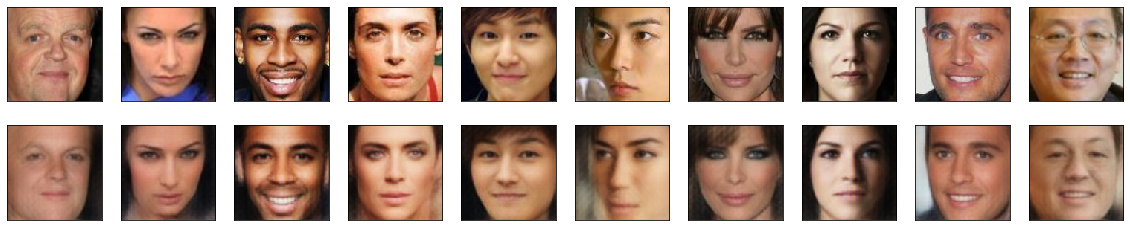

In [11]:
#@title # Test DFC-VAE with loss defined on layers 1, 2, 3 {display-mode: "form"}

n = 10
generator = test_ds.make_one_shot_iterator()
x_test = generator.get_next()[0]
x_test = tfds.as_numpy(x_test)
code = Model(encoder.input, encoder.get_layer('mean').output)
encoded_imgs = code.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [8]:
#@title # Train DFC-VAE with loss defined on layers 2, 3, 4 {display-mode: "form"}

#@markdown Set latent space dimension and number of epochs for training:

latent_dim = 100 #@param {type:"slider", min:50, max:150, step:10}
epochs = 3 #@param {type:"slider", min:1, max:10, step:1}

pm = VGG19(include_top=False, weights='imagenet', input_shape=(128, 128, 3))

selected_pm_layers = ['block2_conv1', 'block3_conv1', 'block4_conv1']
selected_pm_layer_weights = [1.0, 0.8, 0.6]
outputs = [pm.get_layer(l).output for l in selected_pm_layers]
model = Model(pm.input, outputs)

input_shape = (128, 128, 3)

encoder, z_mean, z_log_var = encoder_network(input_shape, latent_dim)
z_encoded = encoder.output
decoder = decoder_network(latent_dim)
z_decoded = decoder(z_encoded)

vae = Model(encoder.input, z_decoded)

opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)

vae.compile(optimizer=opt, loss=vae_dfc_loss)

train_iterator = train_ds.make_one_shot_iterator()
val_iterator = val_ds.make_one_shot_iterator()
vae.fit(train_iterator,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=val_iterator,
        validation_steps=validation_steps)

80142336/80134624 [==============================] - 7s 0us/step
Epoch 1/3
2543/2543 [==============================] - 3967s 2s/step - loss: 2241807.0224 - val_loss: 1723476.6327
Epoch 2/3
2543/2543 [==============================] - 3976s 2s/step - loss: 1565547.5984 - val_loss: 1477725.0778
Epoch 3/3
2543/2543 [==============================] - 3913s 2s/step - loss: 1391765.8193 - val_loss: 1365392.0218


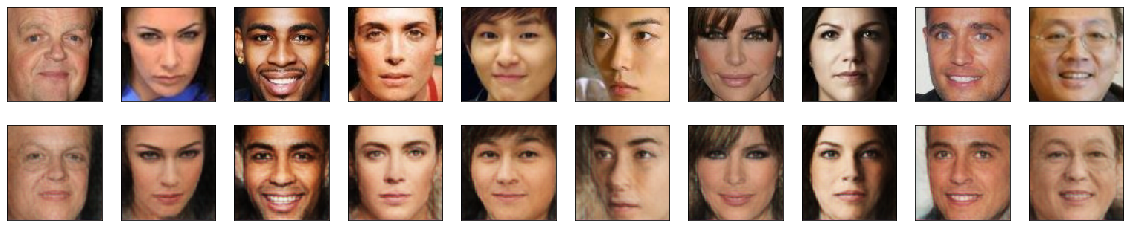

In [9]:
#@title # Test DFC-VAE with loss defined on layers 2, 3, 4 {display-mode: "form"}

n = 10
generator = test_ds.make_one_shot_iterator()
x_test = generator.get_next()[0]
x_test = tfds.as_numpy(x_test)
code = Model(encoder.input, encoder.get_layer('mean').output)
encoded_imgs = code.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Facial Atrribute Manipulation

In [12]:
#@title # Generate smiling vector

def get_smiling_vector(code_model, smiling_ds, not_smiling_ds):
    smiling = code_model.predict(smiling_ds).mean(axis=0)
    not_smiling = code_model.predict(not_smiling_ds).mean(axis=0)
    smile_vector = smiling - not_smiling
    return smile_vector

code_model = Model(encoder.input, encoder.get_layer('mean').output)
smile_vector = get_smiling_vector(code_model, smiling_ds, not_smiling_ds)
print('Done.')

Done.


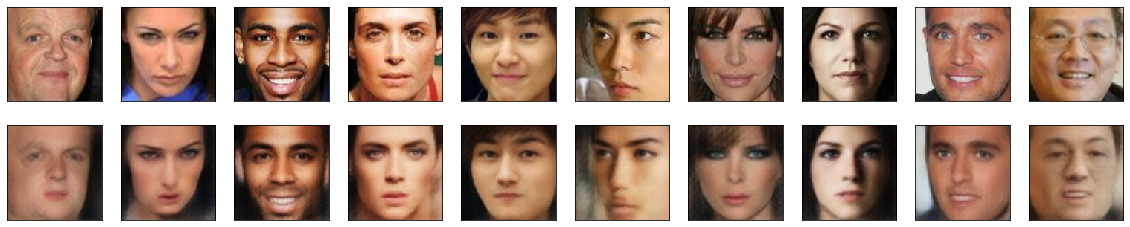

In [14]:
#@title # Add smile to faces

smile_factor = -1 #@param {type:"slider", min:-1, max:1, step:0.1}

generator = test_ds.make_one_shot_iterator()
x_test = generator.get_next()[0]
x_test = tfds.as_numpy(x_test)

encoded_imgs = code_model.predict(x_test)
encoded_imgs = encoded_imgs + smile_factor * smile_vector
decoded_imgs = decoder.predict(encoded_imgs)
n = 10

plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

End of file.